In [118]:
import pandas as pd
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
# Read from CSV

df1 = pd.read_csv('Outputs/packets-udp-rfc761-plaintext-dinamico-2021.09.27-processed')
df2 = pd.read_csv('Outputs/packets-udp-rfc761-encrypted-dinamico-2021.09.27-processed')

In [120]:
# Filtering by port

is_port = df1['dstport']==20001
#print(is_port.head())
df1 = df1[is_port]
is_port = df2['dstport']==20001
df2 = df2[is_port]

In [121]:
# Filtering by the number of packets of chosen size

is_bytes = df1['payload_size']>2
df1 = df1[is_bytes]
is_bytes = df2['payload_size']>2
df2 = df2[is_bytes]

In [122]:
# Sort dataframe by an index (column) and show

df1 = df1.sort_values('shannon')
df2 = df2.sort_values('shannon')
print(df2.iloc[:,6:11])

     payload_size   shannon      bien     tbien
94            225  0.631099  0.455663  0.935441
89           1032  0.695160  0.236018  0.936314
84           1032  0.695160  0.950885  0.973028
156          1032  0.695160  0.950402  0.967231
69           1032  0.695160  0.948715  0.962636
..            ...       ...       ...       ...
4            1032  0.831955  0.460083  0.946810
125          1032  0.831955  0.453359  0.897965
98           1032  0.863205  0.472869  0.944570
104          1032  0.863205  0.952650  0.959822
144          1032  0.863205  0.926134  0.949778

[157 rows x 4 columns]


In [123]:
df = df1.iloc[:,7:10]
df = df.rename(columns={"shannon":"plaintext_shannon","bien":"plaintext_bien","tbien":"plaintext_tbien"})


In [124]:
df['encrypted_shannon'] = df2['shannon'].values
df = df.reset_index()
df

,index,plaintext_shannon,plaintext_bien,plaintext_tbien,encrypted_shannon
0,123,0.632660,0.461807,0.953775,0.631099
1,124,0.644455,0.944600,0.964611,0.695160
2,119,0.656250,0.914152,0.912518,0.695160
3,64,0.662349,0.461527,0.931501,0.695160
4,126,0.675705,0.459005,0.949543,0.695160
...,...,...,...,...,...
152,57,0.800705,0.935036,0.966221,0.831955
153,91,0.800705,0.953136,0.963263,0.831955
154,74,0.800705,0.472357,0.946168,0.863205
155,120,0.800705,0.451375,0.933010,0.863205


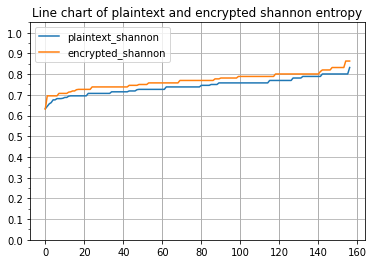

In [125]:
# Plot 1

title = 'Line chart of plaintext and encrypted shannon entropy'
ax = df.plot(y=['plaintext_shannon','encrypted_shannon'],kind='line',title=title, grid=True)
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=1)
ymajortick = arange(0,1.1,0.1)
yminortick = arange(0,1.1,0.05)
ax.set_yticks( ymajortick, minor=False )
ax.set_yticks( yminortick, minor=True )
ax.grid('on', which='both', axis='x' )
plt.savefig('Plots/rfc761/udpshannonlinecomparison.png', transparent=False)

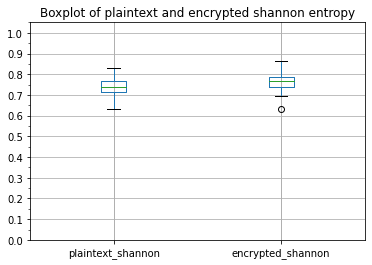

In [126]:
# Plot 2

title = 'Boxplot of plaintext and encrypted shannon entropy'
ax = df.plot(y=['plaintext_shannon','encrypted_shannon'],kind='box',title=title, grid=True)
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=1)
ymajortick = arange(0,1.1,0.1)
yminortick = arange(0,1.1,0.05)
ax.set_yticks( ymajortick, minor=False )
ax.set_yticks( yminortick, minor=True )
ax.grid('on', which='both', axis='x' )
plt.savefig('Plots/rfc761/udpshannonboxcomparison.png', transparent=False)